In [27]:
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
from dotenv import load_dotenv
import os 

In [10]:
csv_path  = "./data/ustr_2023_press_releases_tailed.csv"
df = pd.read_csv(csv_path, encoding='utf-8',delimiter=',',index_col=0)

In [11]:
tokenizer = tiktoken.get_encoding("cl100k_base")

In [7]:
for i,row in df.iterrows():
    if row['content'] == '': # skip empty rows
        continue
    tokens = tokenizer.encode(row['content'])
    print(len(tokens))
    break 
    # df.at[i, 'num_tokens'] = len(tokens)

585


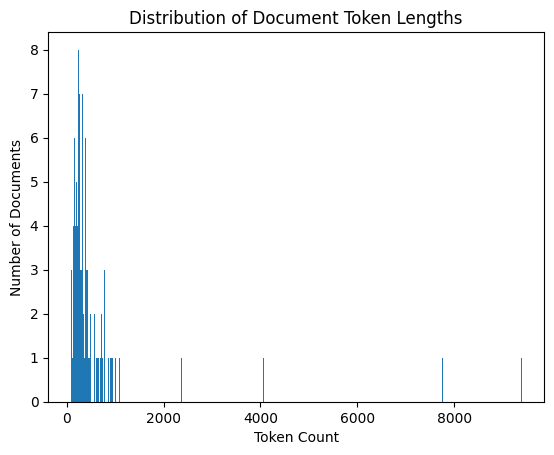

In [15]:
token_counts = [
    len(tokenizer.encode(text))
    for text in df['content']
    if isinstance(text, str) and text.strip()
]

# 4) 히스토그램 그리기
plt.hist(token_counts, bins=1000)
plt.xlabel('Token Count')
plt.ylabel('Number of Documents')
plt.title('Distribution of Document Token Lengths')
plt.show()

In [21]:
df['token_count'] = df['content'].apply(
    lambda x: len(tokenizer.encode(x))
    if isinstance(x, str) and x.strip()
    else 0
)

# 3) 2,000 토큰 초과하는 문서의 "ID" 추출
long_ids = df.loc[df['token_count'] > 2000].index.tolist()

print("토큰 수 2000 초과 문서의 ID들:", long_ids)


토큰 수 2000 초과 문서의 ID들: [182, 187, 216, 312]


In [22]:
df.iloc[182]

title          Readout of Ambassador Katherine Tai’s Meeting ...
date                                                  2023-02-16
url            https://ustr.gov/about-us/policy-offices/press...
content        KUALA LUMPUR – United States Trade Representat...
token_count                                                  253
Name: 294, dtype: object

In [24]:
df.loc[182,'url']

'https://ustr.gov/about-us/policy-offices/press-office/press-releases/2023/may/us-eu-joint-statement-trade-and-technology-council'

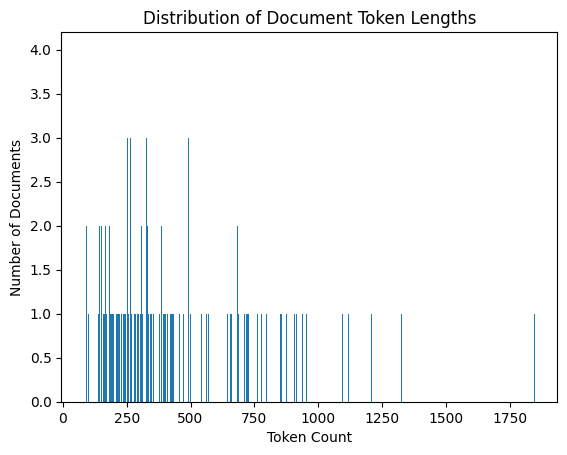

In [26]:
token_counts = [
    len(tokenizer.encode(text))
    for text in df['content']
    if isinstance(text, str) and text.strip() and len(tokenizer.encode(text)) < 2000
]

# 4) 히스토그램 그리기
plt.hist(token_counts, bins=1000)
plt.xlabel('Token Count')
plt.ylabel('Number of Documents')
plt.title('Distribution of Document Token Lengths')
plt.show()

In [29]:


load_dotenv()
# 1) 조회할 Entity Type 리스트
entity_types = [
    # 1. Geography & Facilities
    "Country", "Region", "Location", "Port", "Facility",
    # 2. Legal, Policy & Trade Instruments
    "Contract", "Agreement", "Quota", "Regulation", "Policy",
    "DesignationStatus", "EligibilityCriteria", "TariffMeasure",
    # 3. Products, Materials & Sectors
    "Product", "ProductCategory", "Material", "Industry", "Technology",
    # 4. Logistics & Supply-chain Flows
    "Shipment", "DeliveryStatus", "DemandForecast", "TradeFlow", "Date",
    # 5. Risk, Issues & Crisis
    "RiskEvent", "Crisis", "Issue", "LaborRight", "Mitigation",
    # 6. Economic Metrics
    "EconomicIndicator",
    # 7. Actions, Intentions & Effects
    "Action", "Intention", "Effect",
    # 8. Documents & Processes
    "Document", "ReviewProcess"
]

# 2) 드라이버 초기화 (URI, 사용자/비밀번호를 실제 환경에 맞게 수정)
driver = GraphDatabase.driver(
            os.getenv("NEO4J_URI"),
            auth=(os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD")),
        )

def count_entities(tx, label: str) -> int:
    """주어진 레이블의 노드 개수를 리턴"""
    result = tx.run(
        f"""
        MATCH (n:`{label}`)
        RETURN count(n) AS cnt
        """
    )
    return result.single()["cnt"]

with driver.session(database=os.getenv("NEO4J_DATABASE")) as session:
    for etype in entity_types:
        cnt = session.execute_read(count_entities, etype)
        print(f"{etype:20s}: {cnt}")

driver.close()

/var/folders/gy/skthp76510dbw269jt1xdysr0000gn/T/ipykernel_45010/2665893336.py:41: DeprecationWarning: read_transaction has been renamed to execute_read
  cnt = session.read_transaction(count_entities, etype)


Country             : 735
Region              : 128
Location            : 261
Port                : 0
Facility            : 165
Contract            : 17
Agreement           : 286
Quota               : 9
Regulation          : 102
Policy              : 310
DesignationStatus   : 5
EligibilityCriteria : 3
TariffMeasure       : 11
Product             : 64
ProductCategory     : 18
Material            : 8
Industry            : 74
Technology          : 32
Shipment            : 1


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownLabelWarning} {category: UNRECOGNIZED} {title: The provided label is not in the database.} {description: One of the labels in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing label name is: DeliveryStatus)} {position: line: 2, column: 18, offset: 18} for query: '\n        MATCH (n:`DeliveryStatus`)\n        RETURN count(n) AS cnt\n        '


DeliveryStatus      : 0
DemandForecast      : 1
TradeFlow           : 4
Date                : 311
RiskEvent           : 6
Crisis              : 23
Issue               : 130
LaborRight          : 75
Mitigation          : 9
EconomicIndicator   : 26
Action              : 130
Intention           : 25
Effect              : 15
Document            : 473
ReviewProcess       : 7
